# Volatility Project by Jakub and Timotej

If you need to install any of those libraries, just uncomment and run the cell below. Those are the ones used in our project.

In [1]:
#!pip install pandas
#!pip install arch

Importing libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import plotly.graph_objects as go
from arch import arch_model

This class is used to load data from current folder. You can pass as a parameter the path where the files are located. Otherwise the current path is used.

In [4]:
import DataReader as rd
import importlib
importlib.reload(rd)
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

reader = rd.DataReader()
data = reader.ReadData()

Base path: /Users/jakubmichalski/IES/Volatility-project
Loaded VIX from VIX_History.csv
Loaded SOFR from SOFR.xlsx
Loaded GDP from GDP.xlsx
Loaded GNI from GNI.xlsx
Loaded GNP from GNP.xlsx
Loaded Unemployment from Unemployment.xlsx
Loaded CPI from CPI.xlsx
Loaded PPI from PPI.xlsx


This class is used to preprocess input data. It cleans each of the components and returns dataset for further analysis.


In [5]:
import DataPreprocessor as dp
#potom importlib odstranit
importlib.reload(dp)

dataPreprocessor = dp.DataPreprocessor(data)
dataset = dataPreprocessor.SetSameInterval()

In [7]:
VIX = pd.read_csv(r"VIX_History.csv", parse_dates=['DATE'])
TenYear = pd.read_csv(r"DGS10.csv", parse_dates=['observation_date'])
SOFR = pd.read_excel(r"SOFR.xlsx", parse_dates=['Effective Date'])
GDP = pd.read_excel(r"GDP.xlsx", parse_dates=['GDP Final*'])
GNI = pd.read_excel(r"GNI.xlsx", parse_dates=['Period'])
GNP = pd.read_excel(r"GNP.xlsx", parse_dates=['Period'])
Unemployment = pd.read_excel(r"Unemployment.xlsx", parse_dates=['Original Release Date'])
CPI = pd.read_excel(r"CPI.xlsx", parse_dates=['Original Release Date'])
PPI = pd.read_excel(r"PPI.xlsx", parse_dates=['Original Release Date'])

In [8]:
VIX.rename(columns={'DATE': 'Date', 'CLOSE': 'Value'}, inplace=True)
TenYear.rename(columns={'observation_date': 'Date', 'DGS10': 'Value'}, inplace=True)
SOFR.rename(columns={'Effective Date': 'Date', 'Rate (%)': 'Value'}, inplace=True)
GDP.rename(columns={'GDP Final*': 'Date', 'GDP Final*.1': 'Value'}, inplace=True)
GNI.rename(columns={'Period': 'Date'}, inplace=True)
GNP.rename(columns={'Period': 'Date'}, inplace=True)
Unemployment.rename(columns={'Original Release Date': 'Date', 'First Release': 'Value'}, inplace=True)
CPI.rename(columns={'Original Release Date': 'Date', 'First Release': 'Value'}, inplace=True)
PPI.rename(columns={'Original Release Date': 'Date'}, inplace=True)
VIX = VIX[VIX['Date'] >= '2015-01-01']

In [9]:
#PPI
def change_calculation(df):
    df['Value'] = (df['First Release'] - df['First Release'].shift(-1))
    df['Value'] = df['Value'].fillna(0)
    return df

PPI = change_calculation(PPI)

#GNI
def pct_change(df):
    df['Value'] = ((df['aUSN0ZGFT'] / df['aUSN0ZGFT'].shift(-1)) - 1) * 100
    df['Value'] = df['Value'].fillna(0)
    return df

GNI = pct_change(GNI)

#GNP
def pct_changee(df):
    df['Value'] = ((df['aUSGNP/A'] / df['aUSGNP/A'].shift(-4)) - 1) * 100
    df['Value'] = df['Value'].fillna(0)
    return df

GNP = pct_changee(GNP)

In [10]:
#CorrelationFunction
def correlationfunction(data1, data2, col1, col2):
    merged_data = pd.merge_asof(data1.sort_values('Date'),
                                data2.sort_values('Date'),
                                on='Date')
    correlation = merged_data[[col1, col2]].corr().iloc[0, 1]
    
    return correlation

Heatmap of our indicators.


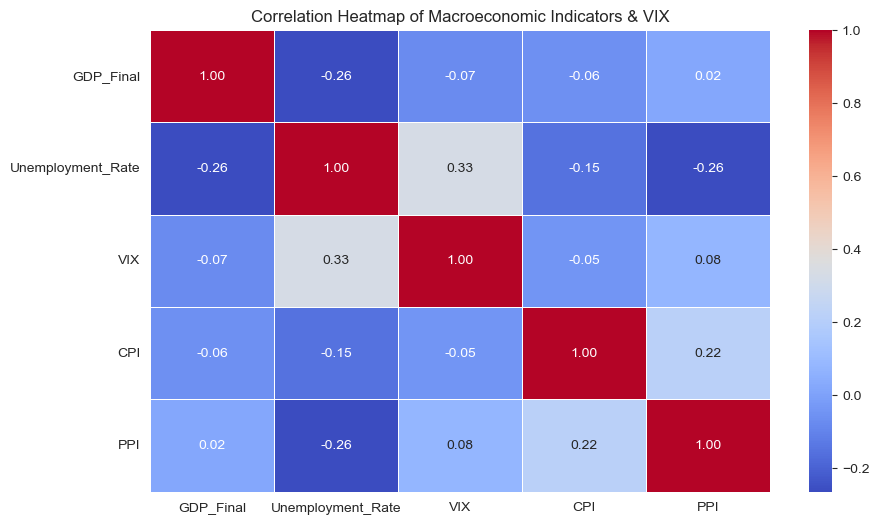

In [11]:
correlation_matrix = dataset.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Macroeconomic Indicators & VIX")
plt.show()

Augumented Dickey-Fuller test to asses whether or not our data are stationary.


In [19]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    """Runs Augmented Dickey-Fuller (ADF) test and prints results."""
    result = adfuller(series.dropna())
    print(f"🔹 {series.name} ADF Test Results:")
    print(f"   ADF Statistic: {result[0]:.3f}")
    print(f"   p-value: {result[1]:.4f}")
    print(f"   Critical Values: {result[4]}")
    if result[1] < 0.05:
        print("   ✅ Stationary (Reject H0)\n")
    else:
        print("   ❌ Non-Stationary (Fail to Reject H0, Consider Differencing)\n")
for col in dataset.columns:
    check_stationarity(dataset[col])

🔹 GDP_Final ADF Test Results:
   ADF Statistic: -3.072
   p-value: 0.0287
   Critical Values: {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
   ✅ Stationary (Reject H0)

🔹 Unemployment_Rate ADF Test Results:
   ADF Statistic: -3.277
   p-value: 0.0160
   Critical Values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}
   ✅ Stationary (Reject H0)

🔹 VIX ADF Test Results:
   ADF Statistic: -4.679
   p-value: 0.0001
   Critical Values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}
   ✅ Stationary (Reject H0)

🔹 CPI ADF Test Results:
   ADF Statistic: -2.030
   p-value: 0.2735
   Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}
   ❌ Non-Stationary (Fail to Reject H0, Consider Differencing)

🔹 PPI ADF Test Results:
   ADF Statistic: -0.552
   p-value: 0.8815
   Critical Values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10

To asses non-stationarity we try using first differencing. For CPI it worked but the PPI seems to be non-stationary even after first differencing.


In [20]:
df_diff = dataset.copy()
df_diff["CPI"] = df_diff["CPI"].diff()
df_diff["PPI"] = df_diff["PPI"].diff()

df_diff.dropna(inplace=True)
print("\n🔍 **Rechecking Stationarity After Differencing:**")
for col in df_diff.columns:
    check_stationarity(df_diff[col])


🔍 **Rechecking Stationarity After Differencing:**
🔹 GDP_Final ADF Test Results:
   ADF Statistic: -3.056
   p-value: 0.0300
   Critical Values: {'1%': -3.4954932834550623, '5%': -2.8900369024285117, '10%': -2.5819706975209726}
   ✅ Stationary (Reject H0)

🔹 Unemployment_Rate ADF Test Results:
   ADF Statistic: -3.257
   p-value: 0.0169
   Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}
   ✅ Stationary (Reject H0)

🔹 VIX ADF Test Results:
   ADF Statistic: -4.648
   p-value: 0.0001
   Critical Values: {'1%': -3.4885349695076844, '5%': -2.887019521656941, '10%': -2.5803597920604915}
   ✅ Stationary (Reject H0)

🔹 CPI ADF Test Results:
   ADF Statistic: -8.176
   p-value: 0.0000
   Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852}
   ✅ Stationary (Reject H0)

🔹 PPI ADF Test Results:
   ADF Statistic: -2.624
   p-value: 0.0881
   Critical Values: {'1%': -3.4961490537199116, '5%': -2.890320

Finally, PCA analysis that shows that we can reduce dimensionality by dropping PPI indicator and still achieve 84.16% Variance. To get rid of both PPI and CPI we would get 64.92% Variance which is quite low.



🔍 **Explained Variance by Principal Components:**
PC1: 0.3677 (36.77% of variance)
PC2: 0.2815 (28.15% of variance)
PC3: 0.1924 (19.24% of variance)
PC4: 0.1584 (15.84% of variance)


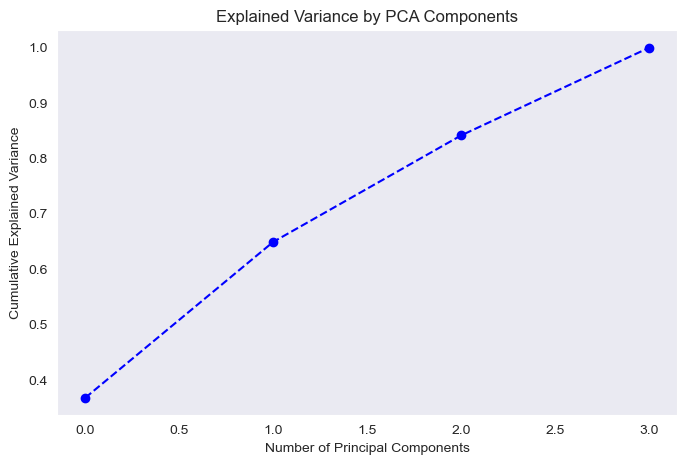

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
macro_features = ["GDP_Final", "Unemployment_Rate", "CPI", "PPI"]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(dataset[macro_features])
pca = PCA(n_components=len(macro_features))
principal_components = pca.fit_transform(df_scaled)
explained_variance = pca.explained_variance_ratio_
print("\n🔍 **Explained Variance by Principal Components:**")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({var * 100:.2f}% of variance)")
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

PC1 has the strongest correlation with VIX (0.1727), but it is still relatively weak.
PC2 and PC3 have even weaker correlations (0.1264 and 0.1083).
VIX is not strongly explained by any single principal component.
Interpretation:
PCA-reduced macroeconomic data may not be the best predictor of VIX.
VIX might be influenced by macroeconomic factors in a non-linear way.
Direct macroeconomic variables (GDP, CPI, etc.) might capture more information than PCA components.

In [22]:
df_pca = pd.DataFrame(principal_components[:, :3], columns=["PC1", "PC2", "PC3"], index=dataset.index)
df_pca["VIX"] = dataset["VIX"]
print(df_pca.corr())

              PC1           PC2           PC3       VIX
PC1  1.000000e+00 -1.266833e-16  2.760300e-17  0.172715
PC2 -1.266833e-16  1.000000e+00  4.076059e-17  0.126441
PC3  2.760300e-17  4.076059e-17  1.000000e+00  0.108289
VIX  1.727150e-01  1.264407e-01  1.082888e-01  1.000000


Interactive Graphs

In [23]:
#InteractiveGraph
def plot_timeseries(dfs, titles):
    fig = go.Figure()
    for i, (df, title) in enumerate(zip(dfs, titles)):
        if i == len(dfs) - 1:
            fig.add_trace(go.Scatter(x=df['Date'], y=df['Value'], mode='lines', name=title, yaxis='y2'))
        else:
            fig.add_trace(go.Scatter(x=df['Date'], y=df['Value'], mode='lines', name=title))

    fig.update_layout(
        title='Time Series Plot',
        xaxis_title='Date',
        yaxis_title='Value',
        yaxis2=dict(overlaying='y', side='right'),
        xaxis=dict(
            rangeslider=dict(visible=True),
            rangeselector=dict(
                buttons=[
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(count=5, label='5y', step='year', stepmode='backward'),
                    dict(step='all')
                ]
            )
        ),
        yaxis=dict(autorange=True)  
    )

    fig.show()

plot_timeseries([TenYear, SOFR, CPI, PPI, Unemployment, GNP, GNI, VIX], ["US 10y yield", "SOFR", "CPI", "PPI", "Unemployment", "GNP", "GNI", "VIX"])

GARCH Model

In [24]:
df = dataset.copy()

#GARCHmodel
def garchmodel(df, col):
    model = arch_model(df[col], vol='Garch', p=1, q=1, mean='Zero', dist='normal')
    garch_result = model.fit(disp='off')
    print(garch_result.summary())

In [25]:
garchmodel(df, "GDP_Final")

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              GDP_Final   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.009
Vol Model:                      GARCH   Log-Likelihood:               -323.627
Distribution:                  Normal   AIC:                           653.255
Method:            Maximum Likelihood   BIC:                           661.541
                                        No. Observations:                  117
Date:                Sun, Feb 02 2025   Df Residuals:                      117
Time:                        23:56:50   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          2.7562      1.153      2.390  1.687e-02 